<a href="https://colab.research.google.com/github/MAYANKTIGER/K-means-clustering-/blob/master/transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## Import Desired Libraries 
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

In [10]:
!pip install tf-nightly-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 582.5 MB 20 kB/s 
     |████████████████████████████████| 1.7 MB 44.7 MB/s 
     |████████████████████████████████| 5.9 MB 39.0 MB/s 
     |████████████████████████████████| 439 kB 66.9 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3


In [3]:
tf. test. gpu_device_name()

''

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


IndexError: ignored

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [20]:
tf.test.is_gpu_available()

False

In [106]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


In [107]:
for i, (image, label) in enumerate(train_ds.take(9)):
  print(label)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


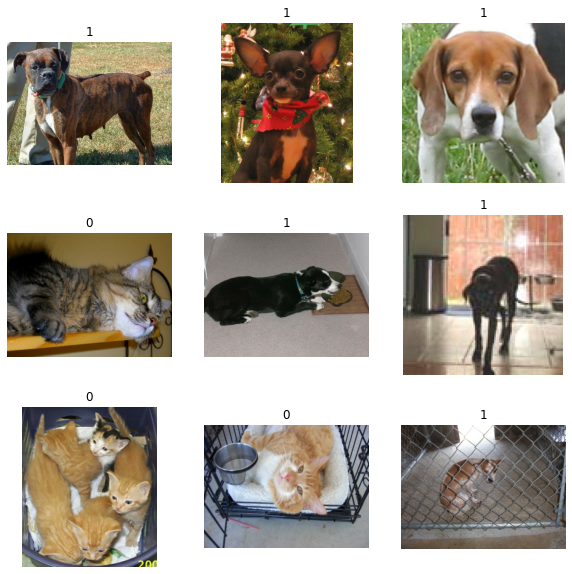

In [108]:
import matplotlib.pyplot as plt
import time 
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    time.sleep(1)
    plt.title(int(label))
    plt.axis("off")
    

In [109]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [110]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [111]:
print(test_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [112]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

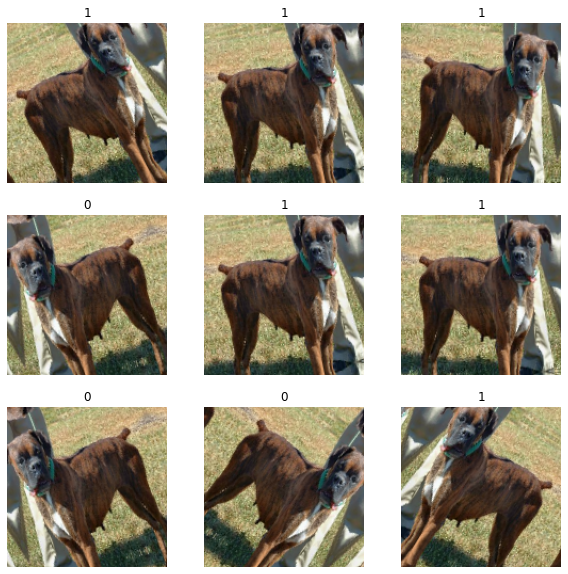

In [113]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [23]:
# base_model = keras.applications.VGG19(
#     weights="imagenet",  # Load weights pre-trained on ImageNet.
#     input_shape=(150, 150, 3),
#     include_top=False,
# )  # Do not include the ImageNet classifier at the top.

# # Freeze the base_model
# base_model.trainable = False

# # Create new model on top
# inputs = keras.Input(shape=(150, 150, 3))
# x = data_augmentation(inputs)  # Apply random data augmentation

# # Pre-trained Xception weights requires that input be normalized
# # from (0, 255) to a range (-1., +1.), the normalization layer
# # does the following, outputs = (inputs - mean) / sqrt(var)
# #keras.layers.experimental.preprocessing.Normalization()
# mean = np.array([127.5] * 3)
# var = mean ** 2
# layer = tf.keras.layers.Normalization(mean=mean, variance=var)
# x = layer(x)
# # norm_layer.set_weights(axis=-1, mean=None, variance=None)

# # Scale inputs to [-1, +1]
# # x = norm_layer(x)
# # norm_layer.set_weights(axis=-1, mean, var)

# # The base model contains batchnorm layers. We want to keep them in inference mode
# # when we unfreeze the base model for fine-tuning, so we make sure that the
# # base_model is running in inference mode here.
# x = base_model(x, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# outputs = keras.layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 normalization_10 (Normaliza  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 512)               0   

In [114]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
#keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
layer = tf.keras.layers.Normalization(mean=mean, variance=var)
x = layer(x)
# norm_layer.set_weights(axis=-1, mean=None, variance=None)

# Scale inputs to [-1, +1]
# x = norm_layer(x)
# norm_layer.set_weights(axis=-1, mean, var)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 normalization_13 (Normaliza  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0   

In [116]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

epochs = 3
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/3
291/291 [==============================] - 25s 79ms/step - loss: 0.1658 - accuracy: 0.9305 - val_loss: 0.0811 - val_accuracy: 0.9665
Epoch 2/3
291/291 [==============================] - 22s 77ms/step - loss: 0.1178 - accuracy: 0.9531 - val_loss: 0.0763 - val_accuracy: 0.9695
Epoch 3/3
291/291 [==============================] - 23s 79ms/step - loss: 0.1162 - accuracy: 0.9557 - val_loss: 0.0743 - val_accuracy: 0.9678


In [118]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

epochs = 2
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 normalization_13 (Normaliza  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0   

In [27]:
predictions = model.predict(test_ds)

In [28]:
predictions

array([[-7.8746157],
       [ 9.965233 ],
       [ 9.134274 ],
       ...,
       [-3.4645948],
       [ 8.4540415],
       [ 7.538457 ]], dtype=float32)

In [30]:
print(model.evaluate(x=test_ds))

73/73 [==============================] - 5s 62ms/step - loss: 0.0638 - binary_accuracy: 0.9789
[0.06376029551029205, 0.9789338111877441]


In [90]:
import cv2 
path = r'/content/dog.jpg'

In [91]:
img = cv2.imread(path)

In [92]:
final_image = img/255

In [93]:
final_image.shape

(635, 640, 3)

(-0.5, 639.5, 634.5, -0.5)

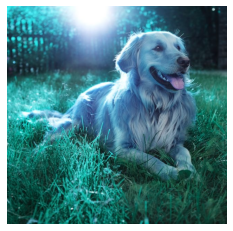

In [94]:
plt.imshow(final_image)
plt.axis('off')

In [54]:
new_input = resized.reshape(1,150, 150, 3)

ValueError: ignored

In [48]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [95]:
print('Original Dimensions : ',final_image.shape)
 
scale_percent = 40 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)

Original Dimensions :  (635, 640, 3)
Resized Dimensions :  (254, 256, 3)


In [96]:
resized = cv2.resize(img, (150,150), interpolation = cv2.INTER_AREA)
 

In [97]:
resized.shape

(150, 150, 3)

In [98]:
new_input = resized.reshape(1,150, 150, 3)

In [79]:
#resized.reshape(1,150,150,3)

In [80]:
pred = model.predict(new_input)

In [89]:
pred[0][0]

-8.665871

In [99]:
pred = model.predict(new_input)

In [101]:
pred[0][0]

11.9703045